In [1]:
import csv
import numpy as np;
import tensorflow as tf
import numpy as np
import math;
import random;
import seaborn as sns 
import matplotlib.pyplot as plt;
import pickle
import sklearn.preprocessing as preprocessing

In [2]:
! ls

Deep Input-Output Regression.ipynb
DeepIO_Regression.py
DeepIO_Regression.py~
DeepIO_Regression_GPU0.py
DeepIO_Regression_GPU0.py~
DeepIO_Regression_GPU1.py
DeepIO_Regression_GPU2.py
DeepIO_Regression_GPU3.py
DeepIO_Regression_GPU3.py~
High_variance_genes.csv
NAND_Titration_IO_data_NAND_Circuit_full.pickle
NAND_Titration_IO_data_empty_landing_pads_full.pickle
RNAseq_merged.csv
all_error_history.pdf
alt_data
outputs.pdf
varied_genes_heatmap.png


In [3]:
#file_obj = open('NAND_Titration_IO_data_empty_landing_pads_full.pickle','rb')
#file_obj = open('NAND_Titration_IO_data_MG1655_empty_landing_pads.pickle','rb')
file_obj = open('NAND_Titration_IO_data_NAND_Circuit_full.pickle','rb')
allVars = pickle.load(file_obj)
Udata_raw = allVars[0]  #Output Data 
Ydata_raw = allVars[1]  #Input Data
print("Ydata shape:" + repr(Ydata_raw.shape));
print("Udata shape:" + repr(Udata_raw.shape));

Ydata_raw_orig = (np.asarray(Ydata_raw,dtype=np.float32))
Ydata_raw =  np.zeros((np.int(Ydata_raw_orig.shape[0]/4),Ydata_raw_orig.shape[1]));
for ind in range(0,Ydata_raw_orig.shape[0]):
    if ind%4 ==0:
        Ydata_raw[np.int(ind/4)] = Ydata_raw_orig[ind]
Udata_raw_orig = np.log2(np.asarray(Udata_raw,dtype=np.float32)+1e-15)
Udata_raw =  np.zeros((np.int(Udata_raw_orig.shape[0]/4),Udata_raw_orig.shape[1]));
for ind in range(0,Udata_raw_orig.shape[0]):
    if ind%4 ==0:
        Udata_raw[np.int(ind/4)] = Udata_raw_orig[ind]


YmmS = preprocessing.StandardScaler();
UmmS = preprocessing.Normalizer();
Ydata = YmmS.fit_transform(Ydata_raw.T)
Udata = UmmS.fit_transform(Udata_raw.T)*-1e1
#UmmS.inverse_transform(....)
Ydata = Ydata[-31:-1,:];

Ydata shape:(480, 4110)
Udata shape:(480, 2)


In [4]:
Ydata_raw_orig

array([[ 451.26465 , 1269.9719  ,  734.2119  , ...,   31.929102,
          48.30983 ,    0.      ],
       [ 200.95833 ,  141.08694 ,  119.411896, ...,   20.854166,
         113.59105 ,    0.      ],
       [ 726.01886 , 2500.4426  , 1417.0377  , ...,   38.495697,
          45.19486 ,    0.      ],
       ...,
       [ 255.67493 ,   75.36338 ,   47.024456, ...,    0.      ,
          45.637714,    0.      ],
       [ 473.06277 ,  427.9081  ,  351.78268 , ...,  107.76165 ,
          47.483887,    0.      ],
       [  74.30286 ,   90.394264,   72.534874, ...,   15.421347,
          44.946777,    0.      ]], dtype=float32)

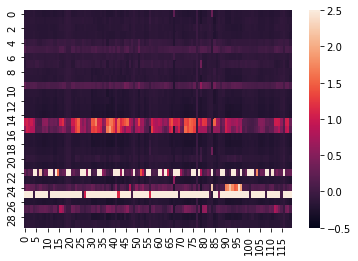

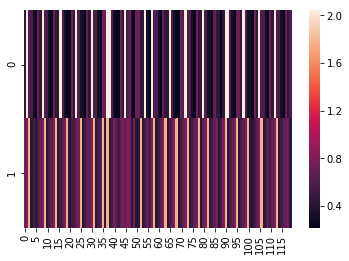

In [5]:
import seaborn as sns 
plt.figure()
sns.heatmap(Ydata,vmin=-0.5,vmax=2.5)
plt.figure()
sns.heatmap(Udata)
#print(Udata[0:10])


In [6]:
print(Udata.shape)
print(Ydata.shape)
K = np.dot(Ydata,np.linalg.pinv(Udata))
#K = np.dot(np.linalg.pinv(Udata),Ydata)
#print(K.shape)
np.linalg.norm(Ydata - np.dot(K,Udata),ord=2)/np.linalg.norm(Ydata,ord=2)

(2, 120)
(30, 120)


0.5792077667067381

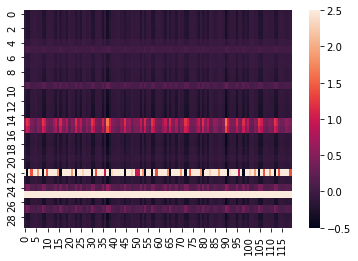

In [7]:
sns.heatmap(np.dot(K,Udata),vmin=-0.5,vmax=2.5)

In [8]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=50)
# pca.fit(Ydata)  
# PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
#   svd_solver='auto', tol=0.0, whiten=False)
# print(pca.explained_variance_ratio_)  
# print(pca.singular_values_)  
# Ydata = pca.transform(Ydata)


In [9]:
def expose_deep_basis(z_list,num_bas_obs,deep_dict_size,iter_num,u):
    basis_hooks = z_list[-1]; #[-1] is y  = K *\phi; -2 is \phi(yk)
    x_range = np.arange(-10.0,10.0,0.1);

    for i in range(0,num_bas_obs):
        plt.close();
        scan_injection = np.zeros((len(x_range),num_bas_obs));
        scan_injection[:,i]= np.transpose(x_range);
        phi_j = basis_hooks.eval(feed_dict={u:scan_injection});
        fig_hand = plt.gcf()
        plt.plot(x_range,phi_j,'.-',label='\phi_i(y)');
        #plt.ylim([-2.0,2.0]);
        fig = plt.gcf();
        plt.savefig('deep_basis_images/phi_with_u' + repr(i) + '_iternum_' + repr(iter_num) + '.jpg');

    return fig_hand;        

def xavier_init(n_inputs, n_outputs, uniform=True):
    """Set the parameter initialization using the method described.
    This method is designed to keep the scale of the gradients roughly the same
    in all layers.
    Xavier Glorot and Yoshua Bengio (2010):
       Understanding the difficulty of training deep feedforward neural
       networks. International conference on artificial intelligence and
       statistics.
    Args:
    n_inputs: The number of input nodes into each output.
    n_outputs: The number of output nodes for each input.
    uniform: If true use a uniform distribution, otherwise use a normal.
    Returns:
    An initializer.
    """
    if uniform:
        # 6 was used in the paper.
        init_range = math.sqrt(6.0 / (n_inputs + n_outputs))
        return tf.random_uniform_initializer(-init_range, init_range)
    else:
        # 3 gives us approximately the same limits as above since this repicks
        # values greater than 2 standard deviations from the mean.
        stddev = math.sqrt(3.0 / (n_inputs + n_outputs))
        return tf.truncated_normal_initializer(stddev=stddev)

def weight_variable(shape):
    std_dev = math.sqrt(3.0 /(shape[0] + shape[1]))
    return tf.Variable(tf.truncated_normal(shape, mean=0.0,stddev=std_dev,dtype=tf.float32));
  
def bias_variable(shape):
    std_dev = math.sqrt(3.0 / shape[0])
    return tf.Variable(tf.truncated_normal(shape, mean=0.0,stddev=std_dev,dtype=tf.float32));


def network_assemble(input_var,W_list,b_list,keep_prob=1.0,activation_flag=1,res_net=0):
    n_depth = len(W_list);
    print("n_depth: " + repr(n_depth));
    z_temp_list = [];
    
    for k in range(0,n_depth):
        
        if (k==0):
            W1 = W_list[0];
            b1 = b_list[0];
            if activation_flag==1:# RELU
                z1 = tf.nn.dropout(tf.nn.relu(tf.matmul(input_var,W1)+b1),keep_prob);
            if activation_flag==2: #ELU 
                z1 = tf.nn.dropout(tf.nn.elu(tf.matmul(input_var,W1)+b1),keep_prob);
            if activation_flag==3: # tanh
                z1 = tf.nn.dropout(tf.nn.tanh(tf.matmul(input_var,W1)+b1),keep_prob);

            z_temp_list.append(z1);
            

        if not (k==0) and k < (n_depth-1):
            
            prev_layer_output = tf.matmul(z_temp_list[k-1],W_list[k])+b_list[k]

            if res_net and k==(n_depth-2):
                prev_layer_output += tf.matmul(u,W1)+b1 #  this expression is not compatible for variable width nets (where each layer has a different width at inialization - okay with regularization and dropout afterwards though)

            if activation_flag==1:
                z_temp_list.append(tf.nn.dropout(tf.nn.relu(prev_layer_output),keep_prob));
            if activation_flag==2:
                z_temp_list.append(tf.nn.dropout(tf.nn.elu(prev_layer_output),keep_prob));
            if activation_flag==3:
                z_temp_list.append(tf.nn.dropout(tf.nn.tanh(prev_layer_output),keep_prob));

                
        if not (k==0) and k == (n_depth-1):
            prev_layer_output = tf.matmul(z_temp_list[k-1],W_list[k])+b_list[k];
            z_temp_list.append(prev_layer_output);

        
    if debug_splash:
        print("[DEBUG] z_list" + repr(z_list[-1]));
        
    #y_out = tf.concat([z_list[-1],u],axis=1); # last element of activation output list is the actual NN output
    y_out = z_temp_list[-1];
    
    result = sess.run(tf.global_variables_initializer())
    return y_out,z_temp_list;


def initialize_Wblist(n_u,hv_list):
    W_list = [];
    b_list = [];
    n_depth = len(hv_list);
    print("Length of hv_list: " + repr(n_depth))
    #hv_list[n_depth-1] = n_y;
    for k in range(0,n_depth):
        
        if k==0:
            W1 = weight_variable([n_u,hv_list[k]]);
            b1 = bias_variable([hv_list[k]]);
            W_list.append(W1);
            b_list.append(b1);
        else:
            W_list.append(weight_variable([hv_list[k-1],hv_list[k]]));
            b_list.append(bias_variable([hv_list[k]]));
    result = sess.run(tf.global_variables_initializer())
    return W_list,b_list;




In [10]:
def train_net(y_all_training,y_feed,u_all_training,u_feed,obj_func,optimizer,u_control_all_training=None,valid_error_thres=1e-2,test_error_thres=1e-2,max_iters=100000,step_size_val=0.01,batchsize=10):

  iter = 0;
  samplerate = 10000;
  good_start = 1;
  valid_error = 100.0;
  test_error = 100.0;
  training_error_history_nocovar = [];
  validation_error_history_nocovar = [];
  test_error_history_nocovar = [];

  training_error_history_withcovar = [];
  validation_error_history_withcovar = [];
  test_error_history_withcovar = [];


  while (((test_error>test_error_thres) or (valid_error > valid_error_thres)) and iter < max_iters):
    iter+=1;
    
    all_ind = set(np.arange(0,len(u_all_training)));
    select_ind = np.random.randint(0,len(u_all_training),size=batchsize);
    valid_ind = list(all_ind -set(select_ind))[0:batchsize];
    select_ind_test = list(all_ind - set(valid_ind) - set(select_ind))[0:batchsize];

    
    u_batch =[];
    u_control_batch = [];
    y_batch = [];
    u_valid = [];
    u_control_valid = [];
    y_valid = [];
    u_test_train = [];
    u_control_train = [];
    y_test_train= [];
    u_control_test_train = [];
    
    for j in range(0,len(select_ind)):
      u_batch.append(u_all_training[select_ind[j]]);  
#      y_batch = embed_feed.eval(feed_dict={u_feed:u_batch});
      y_batch.append(y_all_training[select_ind[j]]);
          
    for k in range(0,len(valid_ind)):
      u_valid.append(u_all_training[valid_ind[k]]);
      y_valid.append(y_all_training[valid_ind[k]]);
#      y_valid = embed_feed.eval(feed_dict={u_feed:u_valid});


    for k in range(0,len(select_ind_test)):
      u_test_train.append(u_all_training[select_ind_test[k]]);
      y_test_train.append(y_all_training[select_ind_test[k]]);  
#    y_test_train = embed_feed.eval(feed_dict={u_feed:u_test_train});
    u_batch = np.asarray(u_batch);
    y_batch = np.asarray(y_batch);
    #print("u_feed:" + repr(u_feed));
    #print("y_feed:" + repr(y_feed));
    optimizer.run(feed_dict={u_feed:u_batch,y_feed:y_batch,step_size:step_size_val});
    valid_error = obj_func.eval(feed_dict={u_feed:u_valid,y_feed:y_valid});
    test_error = obj_func.eval(feed_dict={u_feed:u_test_train,y_feed:y_test_train});

    
    if iter%samplerate==0:
      training_error_history_nocovar.append(obj_func.eval(feed_dict={u_feed:u_batch,y_feed:y_batch}));
      validation_error_history_nocovar.append(obj_func.eval(feed_dict={u_feed:u_valid,y_feed:y_valid}));
      test_error_history_nocovar.append(obj_func.eval(feed_dict={u_feed:u_test_train,y_feed:y_test_train}));

  
      if (iter%10==0) or (iter==1):
        #plt.close();                  
        print ("step %d , validation error %g"%(iter, obj_func.eval(feed_dict={u_feed:u_valid,y_feed:y_valid})));
        print ("step %d , test error %g"%(iter, obj_func.eval(feed_dict={u_feed:u_test_train,y_feed:y_test_train})));
        #print("Reconstruction Loss: " + repr(this_vae_loss.eval(feed_dict={this_u:this_corpus_vec})))
#        this_corpus_embed = embed_feed.eval(feed_dict={u_feed:})
        #print("Embedding Loss: " + repr(this_embed_loss.eval(feed_dict={this_u:this_corpus_vec})) )
    
#    if ((iter>20000) and iter%10) :#
#
#      valid_gradient = np.gradient(np.asarray(validation_error_history_nocovar[iter/samplerate*7/10:]));
#      mu_gradient = np.mean(valid_gradient);
#
#      if ((iter <1000) and (mu_gradient >= 5e-1)): # eventually update this to be 1/10th the mean of batch data, or mean of all data handed as input param to func
#        good_start = 0; # if after 10,000 iterations validation error is still above 1e0, initialization was poor.
#        print("Terminating model refinement loop with gradient:") + repr(mu_gradient) + ", validation error after " + repr(iter) + " epochs:  " + repr(valid_error);
#        iter = max_iters; # terminate while loop and return histories

  all_histories = [training_error_history_nocovar, validation_error_history_nocovar,test_error_history_nocovar];
  
  plt.close();
  x = np.arange(0,len(validation_error_history_nocovar),1);
  plt.plot(x,training_error_history_nocovar,label='train. err.');
  plt.plot(x,validation_error_history_nocovar,label='valid. err.');
  plt.plot(x,test_error_history_nocovar,label='test err.');
  #plt.gca().set_yscale('log');
  plt.savefig('all_error_history.pdf');
  
  plt.close();
  return all_histories,good_start;

In [11]:
def vae_loss(y_model,y_true):
        return tf.norm(y_true - y_model,axis=[0,1],ord='fro')/tf.norm(y_true,axis=[0,1],ord='fro');


In [12]:
Ydata = Ydata.T;
Udata = Udata.T;
print(Ydata.shape)
print(Udata.shape)

(120, 30)
(120, 2)


In [13]:
input_dim_parameter = 2; 
#label_dim = 1; 
intermediate_dim = 20
output_dim = Ydata.shape[1];
batch_size_parameter=40;#4000 for howard's e. coli dataset
debug_splash = 0;
this_step_size_val = 0.025;



In [14]:
sess = tf.InteractiveSession();


In [15]:
hidden_vars_list = [input_dim_parameter] + [intermediate_dim]*1 + [output_dim];

this_u = tf.placeholder(tf.float32, shape=[None,input_dim_parameter],name="InputInducers");
#for d in ['/device:cpu:0']:#, '/device:CPU:3']:

    #with tf.device(d):
with tf.device('/cpu:0'):
    this_W_list,this_b_list = initialize_Wblist(input_dim_parameter,hidden_vars_list);
    this_y_out,all_layers = network_assemble(this_u,this_W_list,this_b_list,keep_prob=1.0,
                                             activation_flag=2,res_net=0)

    this_y_true = tf.placeholder(tf.float32,shape=[None,output_dim],name="Groundtruth_Transcriptome")    
    this_output_layer = all_layers[-3]

    result = sess.run(tf.global_variables_initializer())
    this_io_loss = vae_loss(this_y_out,this_y_true)
    this_optim = tf.train.AdagradOptimizer(learning_rate=this_step_size_val).minimize(this_io_loss)
    step_size = tf.placeholder(tf.float32,shape=[],name="StepSizePlaceholder");
    result = sess.run(tf.global_variables_initializer())
    #this_embed_loss = embed_loss(this_u,this_embedding);

    train_net(Ydata,this_y_true,Udata,this_u,this_io_loss,this_optim,
              batchsize = batch_size_parameter,step_size_val = this_step_size_val,max_iters=5e6)


Length of hv_list: 3
Instructions for updating:
Colocations handled automatically by placer.
n_depth: 3
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
step 10000 , validation error 0.433382
step 10000 , test error 0.423608
step 20000 , validation error 0.443538
step 20000 , test error 0.376913
step 30000 , validation error 0.427712
step 30000 , test error 0.377671
step 40000 , validation error 0.410235
step 40000 , test error 0.361322
step 50000 , validation error 0.411449
step 50000 , test error 0.41037
step 60000 , validation error 0.428294
step 60000 , test error 0.406234
step 70000 , validation error 0.425976
step 70000 , test error 0.39235
step 80000 , validation error 0.419314
step 80000 , test error 0.396511
step 90000 , validation error 0.413905
step 90000 , test error 0.401447
step 100000 , validation error 0.394861
step 100000 , test error 0.432744
step 110000 , validation error 0.409361
step 110000 , test er

KeyboardInterrupt: 

Text(0.5, 1.0, 'Actual IO Response of 30 NAND Circuit Genes')

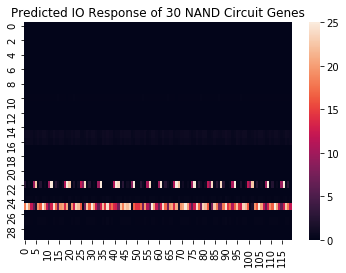

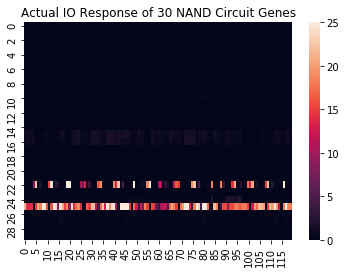

In [23]:
plt.figure()
sns.heatmap(this_y_out.eval(feed_dict={this_u:Udata}).T,vmin=0,vmax=25)
plt.title('Predicted IO Response of 30 NAND Circuit Genes')
plt.figure()
sns.heatmap(Ydata.T,vmin=0,vmax=25)
plt.title('Actual IO Response of 30 NAND Circuit Genes')

YT*U*(U^T*U)^{-1} = G 

In [ ]:
G = np.matmul(Ydata.T,np.matmul(Udata,np.linalg.inv(np.matmul(Udata.T,Udata )) ) )

In [ ]:
U_test = np.array([[0,0],[0,1],[1,0],[1,1]])
output = np.matmul(G,U_test.T)

In [ ]:
Yout = YmmS.inverse_transform(output.T)

In [ ]:
import sklearn.cluster as cluster

In [ ]:
Yclust = cluster.AgglomerativeClustering(n_clusters=10).fit_predict(Yout.T)

In [ ]:
newOrder = [[i,e] for i,e in enumerate(Yclust)]

In [ ]:
nS = np.array(newOrder)

In [ ]:
nS.sort(axis=0)

In [ ]:
from scipy.cluster import hierarchy

In [ ]:
dend = shc.dendrogram(shc.linkage(data_scaled, method='ward'))


In [ ]:
dend = hierarchy.dendrogram(hierarchy.linkage(Yout.T,method='ward'))

In [ ]:
Yout.T[:50]

In [ ]:
Yplot = Yout.T
Yplot[Yplot < 0] = 1e-2

In [ ]:
import pandas as pd
dfM = pd.read_csv('RNAseq_merged.csv')

In [ ]:
geneNames = dfM.columns[7:].values

In [ ]:
dfG = pd.DataFrame(Yplot,index=geneNames)

In [ ]:
dfG.loc[['Sensor_LacI','Sensor_AraC','Circuit_PhlF','Circuit_IcaR','Actuator_YFP']]

In [ ]:
plt.figure(figsize=(6,20))
sns.heatmap(np.log10(Yplot),cmap='viridis')

plt.savefig('outputs.pdf')

In [ ]:
Yout.T[:20]

In [ ]:


this_xlabels = ['arabinose','iptg']
#this_ylabels = ['gene'+repr(ind) for ind in range(0,4110)]
sns.set(font_scale=1.4)
#hm=sns.heatmap(G,xticklabels=this_xlabels,#yticklabels=this_ylabels,cmap='RdYlGn',annot=False)
hm=sns.heatmap((np.log10(G)+1e-15),xticklabels=this_xlabels,cmap='RdYlGn',annot=False)
